## Time Series Analysis of Precipitation and Soil Mositure

In [1]:
import ee
import bqplot
import datetime
import dateutil.parser
import ipywidgets
import IPython.display
import numpy as np
import pprint
import pandas as pd
import traitlets
import ipyleaflet
from matplotlib.pyplot import *
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# authenticate to the Earth Engine
ee.Initialize()

## Load and display GPM Data

In [3]:
gpm_collection = ee.ImageCollection("NASA/GPM_L3/IMERG_V05")

In [4]:
print(gpm_collection.size().getInfo())

86630


In [5]:
# filter gpm collection
gpm_collection_18 = gpm_collection.filterDate('2018-01-01', '2018-12-31')
print(gpm_collection_18.size().getInfo())

17472


In [6]:
# sample gpm image analysis
gpm_image = ee.Image(gpm_collection_18
         #.filterBounds(india_region.geometry())
         .first()
        )

In [7]:
# Get information about the bands as a list.
bandNames = gpm_image.bandNames();
print('Band names: ', bandNames.getInfo()); 

#Get a list of all metadata properties.
properties = gpm_image.propertyNames();
print('Metadata properties: ', properties.getInfo()); 

#Get a specific metadata property.
cloudiness = gpm_image.get('CLOUD_COVER');
print('CLOUD_COVER: ', cloudiness.getInfo()); 

#Get the timestamp and convert it to a date.
date = ee.Date(gpm_image.get('system:time_start'));
print('Timestamp: ', date.getInfo()); 
 
# Get dimensions of imagees
print (gpm_image.geometry().bounds().getInfo());

#pp.pprint(gpm_image.getInfo())

Band names:  ['HQobservationTime', 'HQprecipSource', 'HQprecipitation', 'IRkalmanFilterWeight', 'IRprecipitation', 'precipitationCal', 'precipitationUncal', 'probabilityLiquidPrecipitation', 'randomError']
Metadata properties:  ['system:time_start', 'system:footprint', 'system:time_end', 'system:version', 'system:id', 'system:asset_size', 'status', 'system:index', 'system:bands', 'system:band_names']
CLOUD_COVER:  None
Timestamp:  {'type': 'Date', 'value': 1514764800000}
{'type': 'Polygon', 'coordinates': [[[-180.0, -90.0], [180.0, -90.0], [180.0, 90.0], [-180.0, 90.0], [-180.0, -90.0]]]}


In [8]:
gpm_thumbnail_url = gpm_image.getThumbUrl({
    'bands': 'precipitationCal',
    'min': 1.0,
    'max': 9.0,
    #'region': gpm_image.geometry().bounds().getInfo()
})
IPython.display.HTML('Thumbnail URL: <a href={0}>{0}</a>'.format(gpm_thumbnail_url))
IPython.display.Image(url=gpm_thumbnail_url)

In [9]:
gpm_map = ipyleaflet.Map(zoom=3, layout={'height':'400px'})
gpm_map

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [10]:
def GetTileLayerUrl(ee_image_object):
  map_id = ee.Image(ee_image_object).getMapId()
  tile_url_template = "https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}"
  return tile_url_template.format(**map_id)

In [11]:
# overaly image on map
tile_url = GetTileLayerUrl(gpm_image.visualize(min=1.0, max=9.0, gamma=1.5, bands= ['precipitationCal']))
gpm_map.add_layer(ipyleaflet.TileLayer(url=tile_url))

## Load and display Soil Moisture Data

In [12]:
soil_moist_collection = ee.ImageCollection('NASA_USDA/HSL/SMAP_soil_moisture')

In [13]:
print(soil_moist_collection.size().getInfo())

471


In [14]:
# filter soil moisture collection
soil_moist_collection_18 = soil_moist_collection.filterDate('2018-01-01', '2018-12-31')
print(soil_moist_collection_18.size().getInfo())

122


In [15]:
# sample soil moisture image analysis
soil_moist_image = ee.Image(soil_moist_collection_18.first())

In [16]:
print (soil_moist_image.getInfo())

{'type': 'Image', 'bands': [{'id': 'ssm', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1440, 600], 'crs': 'EPSG:4326', 'crs_transform': [0.25, 0.0, -180.0, 0.0, -0.25, 90.0]}, {'id': 'susm', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1440, 600], 'crs': 'EPSG:4326', 'crs_transform': [0.25, 0.0, -180.0, 0.0, -0.25, 90.0]}, {'id': 'smp', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1440, 600], 'crs': 'EPSG:4326', 'crs_transform': [0.25, 0.0, -180.0, 0.0, -0.25, 90.0]}, {'id': 'ssma', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1440, 600], 'crs': 'EPSG:4326', 'crs_transform': [0.25, 0.0, -180.0, 0.0, -0.25, 90.0]}, {'id': 'susma', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1440, 600], 'crs': 'EPSG:4326', 'crs_transform': [0.25, 0.0, -180.0, 0.0, -0.25, 90.0]}], 'version': 1520631353743166, 'id': 'NASA_USDA/HSL/SMAP_soil_moisture/NASA_USDA_SMAP_SM2

In [17]:
# Get information about the bands as a list.
bandNames = soil_moist_image.bandNames();
print('Band names: ', bandNames.getInfo()); 

#Get a list of all metadata properties.
properties = soil_moist_image.propertyNames();
print('Metadata properties: ', properties.getInfo()); 

#Get a specific metadata property.
cloudiness = soil_moist_image.get('CLOUD_COVER');
print('CLOUD_COVER: ', cloudiness.getInfo());

#Get the timestamp and convert it to a date.
date = ee.Date(soil_moist_image.get('system:time_start'));
print('Timestamp: ', date.getInfo()); 
 
# Get dimensions of imagees
print (soil_moist_image.geometry().bounds().getInfo());

# print image metadata
#pp.pprint(soil_moist_image.getInfo())

Band names:  ['ssm', 'susm', 'smp', 'ssma', 'susma']
Metadata properties:  ['system:time_start', 'system:footprint', 'system:time_end', 'system:version', 'system:id', 'ID', 'system:asset_size', 'system:index', 'system:bands', 'system:band_names']
CLOUD_COVER:  None
Timestamp:  {'type': 'Date', 'value': 1514764800000}
{'type': 'Polygon', 'coordinates': [[[-180.0, -90.0], [180.0, -90.0], [180.0, 90.0], [-180.0, 90.0], [-180.0, -90.0]]]}


In [18]:
soil_moist_thumbnail_url = soil_moist_image.getThumbUrl({
    'bands': 'ssm',
    'min': 0.0,
    'max': 28.0,
})
IPython.display.HTML('Thumbnail URL: <a href={0}>{0}</a>'.format(soil_moist_thumbnail_url))
IPython.display.Image(url=soil_moist_thumbnail_url)

In [19]:
soil_moist_map = ipyleaflet.Map(zoom=3, layout={'height':'400px'})
soil_moist_tile_url = GetTileLayerUrl(soil_moist_image.visualize(min=0.0, max=28.0, gamma=1.5, bands= ['ssm']))
soil_moist_map.add_layer(ipyleaflet.TileLayer(url=soil_moist_tile_url))
soil_moist_map

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

## Aggregate Precipitation and Soil Moisture over a Time Series

In [20]:
from datetime import datetime
from datetime import timedelta

agg_precipitation = [];
agg_soil_moisture = [];

# since Soil Moisture data is available over 3 days, we are aggregating GPM data over 3 days
interval_start_dt = '2018-01-01'
interval_finish_dt = '2018-01-03'
finish_dt = "2018-12-31"
offset_days = 3

#for days in months_days:
while datetime.strptime(interval_finish_dt, '%Y-%m-%d') <= datetime.strptime(finish_dt, '%Y-%m-%d'):
    gpm_current = gpm_collection_18.filterDate(interval_start_dt, interval_finish_dt)
    soil_moist_current = soil_moist_collection_18.filterDate(interval_start_dt, interval_finish_dt)
    
    agg_precipitation.append(gpm_current.reduce(ee.Reducer.sum()));
    agg_soil_moisture.append(soil_moist_current.reduce(ee.Reducer.mean()))
    
    interval_start_dt = datetime.strptime(interval_start_dt, '%Y-%m-%d')
    interval_finish_dt = datetime.strptime(interval_finish_dt, '%Y-%m-%d')
    interval_start_dt = (interval_start_dt + timedelta(days=offset_days)).strftime('%Y-%m-%d')
    interval_finish_dt = (interval_finish_dt + timedelta(days=offset_days)).strftime('%Y-%m-%d')

In [21]:
agg_precipitation_collection = ee.ImageCollection.fromImages(agg_precipitation);
agg_soil_moisture_collection = ee.ImageCollection.fromImages(agg_soil_moisture);
print (agg_precipitation_collection.size().getInfo())
print (agg_soil_moisture_collection.size().getInfo())

121
121


In [22]:
agg_precipitation_map = ipyleaflet.Map(zoom=2, layout={'height':'400px'})
tile_url = GetTileLayerUrl(agg_precipitation_collection.first().visualize(min=1.0, max=9.0, gamma=1.5, bands= ['precipitationCal_sum']))
agg_precipitation_map.add_layer(ipyleaflet.TileLayer(url=tile_url))
agg_precipitation_map

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [23]:
agg_soil_moist_map = ipyleaflet.Map(zoom=3, layout={'height':'400px'})
tile_url = GetTileLayerUrl(agg_soil_moisture_collection.first().visualize(min=0.0, max=28.0, gamma=1.5, bands= ['ssm_mean']))
agg_soil_moist_map.add_layer(ipyleaflet.TileLayer(url=tile_url))
agg_soil_moist_map

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [24]:
# sample point
#point = {'type':'Point', 'coordinates':[-116.88629,36.56122]};
point = {'type':'Point', 'coordinates':[78.486328,23.049091]};

precipitaion_info = agg_precipitation_collection.getRegion(point,500).getInfo()
soil_moisture_info = agg_soil_moisture_collection.getRegion(point,500).getInfo()

In [25]:
# column names and data for precipitation
precipitaion_data_header = precipitaion_info[0]
precipitaion_data = np.array(precipitaion_info[1:])

# column names and data for soil moisture
soil_moisture_data_header = soil_moisture_info[0]
soil_moisture_data = np.array(soil_moisture_info[1:])

print (soil_moisture_data_header)
print (precipitaion_data_header)

['id', 'longitude', 'latitude', 'time', 'ssm_mean', 'susm_mean', 'smp_mean', 'ssma_mean', 'susma_mean']
['id', 'longitude', 'latitude', 'time', 'HQobservationTime_sum', 'HQprecipSource_sum', 'HQprecipitation_sum', 'IRkalmanFilterWeight_sum', 'IRprecipitation_sum', 'precipitationCal_sum', 'precipitationUncal_sum', 'probabilityLiquidPrecipitation_sum', 'randomError_sum']


In [26]:
time_indices = np.arange(0, agg_soil_moisture_collection.size().getInfo())

Text(0, 0.5, 'Values')

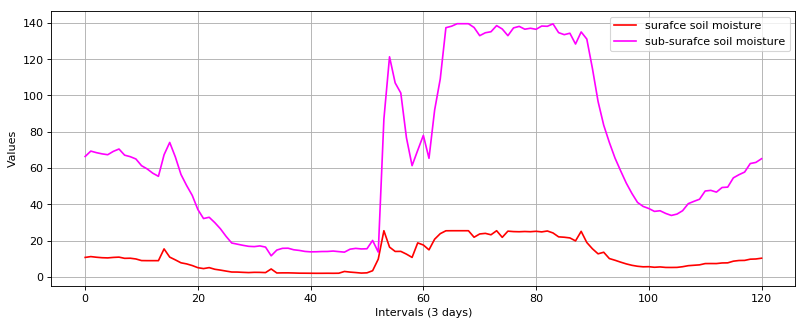

In [27]:
fig = figure(figsize=(12,10), dpi=80)

# plot the soil moisture values
ax1 = fig.add_subplot(211)
ax1.plot(time_indices, soil_moisture_data[:,soil_moisture_data_header.index('ssm_mean')], 
         color="red", label="surafce soil moisture")
ax1.plot(time_indices, soil_moisture_data[:,soil_moisture_data_header.index('susm_mean')], 
         color="magenta",  label="sub-surafce soil moisture")
ax1.legend(loc='best')
ax1.grid(True)
ax1.set_xlabel("Intervals (3 days)")
ax1.set_ylabel("Values")

Text(0, 0.5, 'Values')

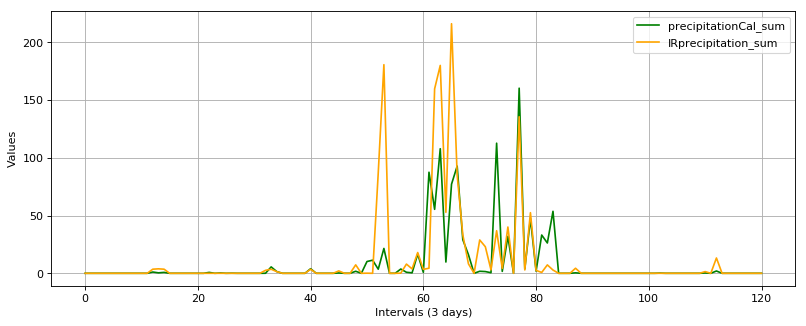

In [28]:
fig2 = figure(figsize=(12,10), dpi=80)

ax2 = fig2.add_subplot(212)
ax2.plot(time_indices, precipitaion_data[:,precipitaion_data_header.index('precipitationCal_sum')], 
         color="green", label="precipitationCal_sum")
ax2.plot(time_indices, precipitaion_data[:,precipitaion_data_header.index('IRprecipitation_sum')], 
         color="orange",  label="IRprecipitation_sum")

ax2.legend(loc='best')
ax2.grid(True)
ax2.set_xlabel("Intervals (3 days)")
ax2.set_ylabel("Values")

## Correlation between Precipitation and Soil Moisture

In [29]:
precipitation = precipitaion_data[:,precipitaion_data_header.index('precipitationCal_sum')]
soil_moisture = soil_moisture_data[:,soil_moisture_data_header.index('ssm_mean')]
precipitation

corr = np.corrcoef(precipitation.astype(float), soil_moisture.astype(float))
print ("\ncorealtion: \n", corr)

cov = np.cov(precipitation.astype(float), soil_moisture.astype(float))
print ("\ncovariance: \n", cov)


corealtion: 
 [[1.         0.49640714]
 [0.49640714 1.        ]]

covariance: 
 [[638.76837322 101.38864825]
 [101.38864825  65.30692406]]


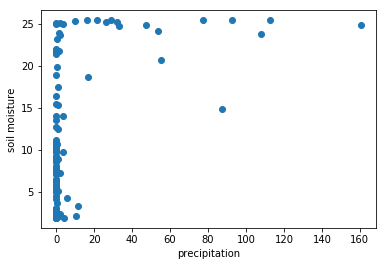

In [30]:
plt.scatter(precipitation, soil_moisture)
plt.xlabel("precipitation")
plt.ylabel("soil moisture")
plt.show()